# The Box-Mueller Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats

%matplotlib inline

In [2]:
plt.rc("figure", figsize=(15,5), dpi=100)

### Algorithm

Inputs:
$$
u_0 \sim \mathcal{U} \\
u_1 \sim \mathcal{U}
$$

Processing steps:

$$
e = -2\ln(u_0) \\
f = \sqrt{e} \\
g_0 = \sin(2\pi u_1) \\
g_1 = \cos(2\pi u_1) \\
x_0 = f \times g_0 \\
x_1 = f \times g_1
$$

In [3]:
def split_range(xmin, xmax, sections):
    length = xmax - xmin
    section_length = length / sections
    
    return [(xmin + i * section_length, xmin + (i+1) * section_length) for i in range(sections)]

In [4]:
def build_approximation_tables(f, xmin, xmax, degree=1, sections=128):
    return np.array([np.polyfit(np.linspace(0, 1, 1024), f(np.linspace(smin, smax, 1024)), degree) for smin, smax in split_range(xmin, xmax, sections)])

In [5]:
def approximate_from_table(table, xmin, xmax, x):
    return np.sum(np.power(np.fmod(x-xmin, (xmax-xmin)/table.shape[0])[:,np.newaxis] * table.shape[0] / (xmax-xmin), (table.shape[1]-1-np.arange(table.shape[1]))[np.newaxis,:]) * table[((x-xmin)/(xmax-xmin)*table.shape[0]).astype(int)], axis=1)

In [6]:
# f = lambda x: np.sin(1/2 * np.pi * x)
f = lambda x: np.log(x)

In [7]:
log_table = build_approximation_tables(np.log, 1, 2, degree=2, sections=256)

sqrt_table_0 = build_approximation_tables(lambda x: np.sqrt(x) - 1, 1, 2, sections=64, degree=1)
sqrt_table_1 = build_approximation_tables(lambda x: np.sqrt(x) - 1, 2, 4, sections=64, degree=1)

sin_table = build_approximation_tables(lambda x: np.sin(np.pi/2 * x), 0, 1, sections=128, degree=1)
cos_table = build_approximation_tables(lambda x: np.cos(np.pi/2 * x), 0, 1, sections=128, degree=1)

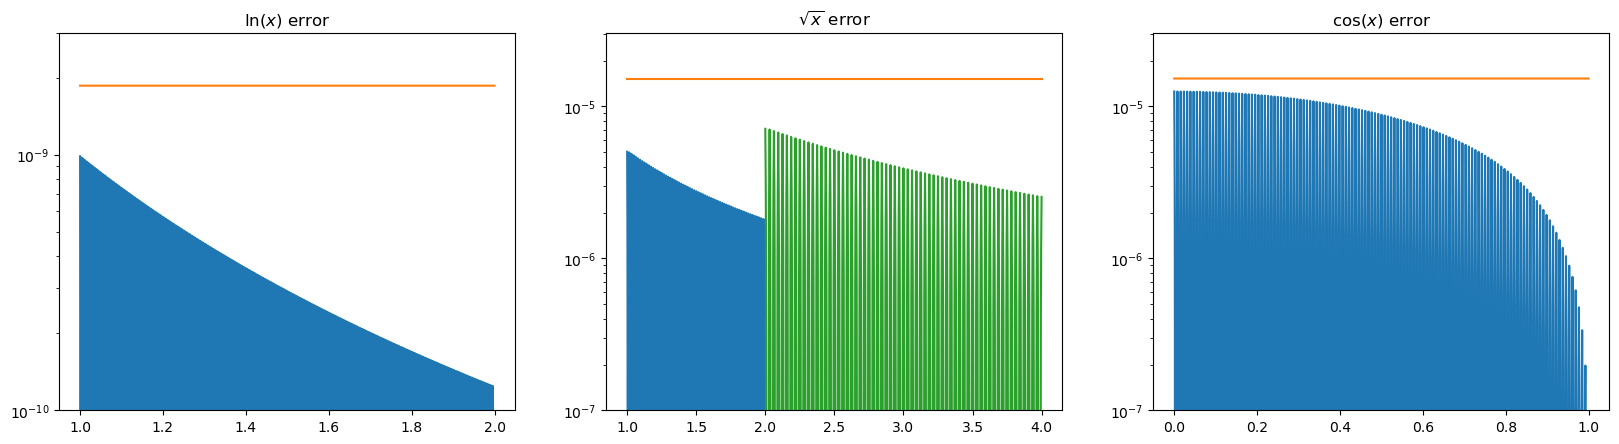

In [8]:
plt.figure(figsize=(20, 5))

error_floor = 2**-16

plt.subplot(1, 3, 1)
plt.title("$\\ln(x)$ error")
x = np.linspace(1, 2, 8192, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(log_table, 1, 2, x)) - f(x))
plt.plot(x, np.ones_like(x) * 2**-29)
plt.yscale("log")
plt.ylim((1e-10, 3e-9));

plt.subplot(1, 3, 2)
plt.title("$\\sqrt{x}$ error")
x = np.linspace(1, 2, 8192 * 8, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(sqrt_table_0, 1, 2, x)) - np.sqrt(x) + 1)
plt.plot(np.linspace(1, 4, 2), np.ones(2) * error_floor)
x = np.linspace(2, 4, 8192 * 8, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(sqrt_table_1, 2, 4, x)) - np.sqrt(x) + 1)
plt.yscale("log")
plt.ylim(1e-7, 2*error_floor);

plt.subplot(1, 3, 3)
plt.title("$\\cos(x)$ error")
x = np.linspace(0, 1, 8192, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(cos_table, 0, 1, x)) - np.cos(x * np.pi/2))
plt.plot(x, np.ones_like(x) * error_floor)
plt.yscale("log")
plt.ylim(1e-7, 2*error_floor);

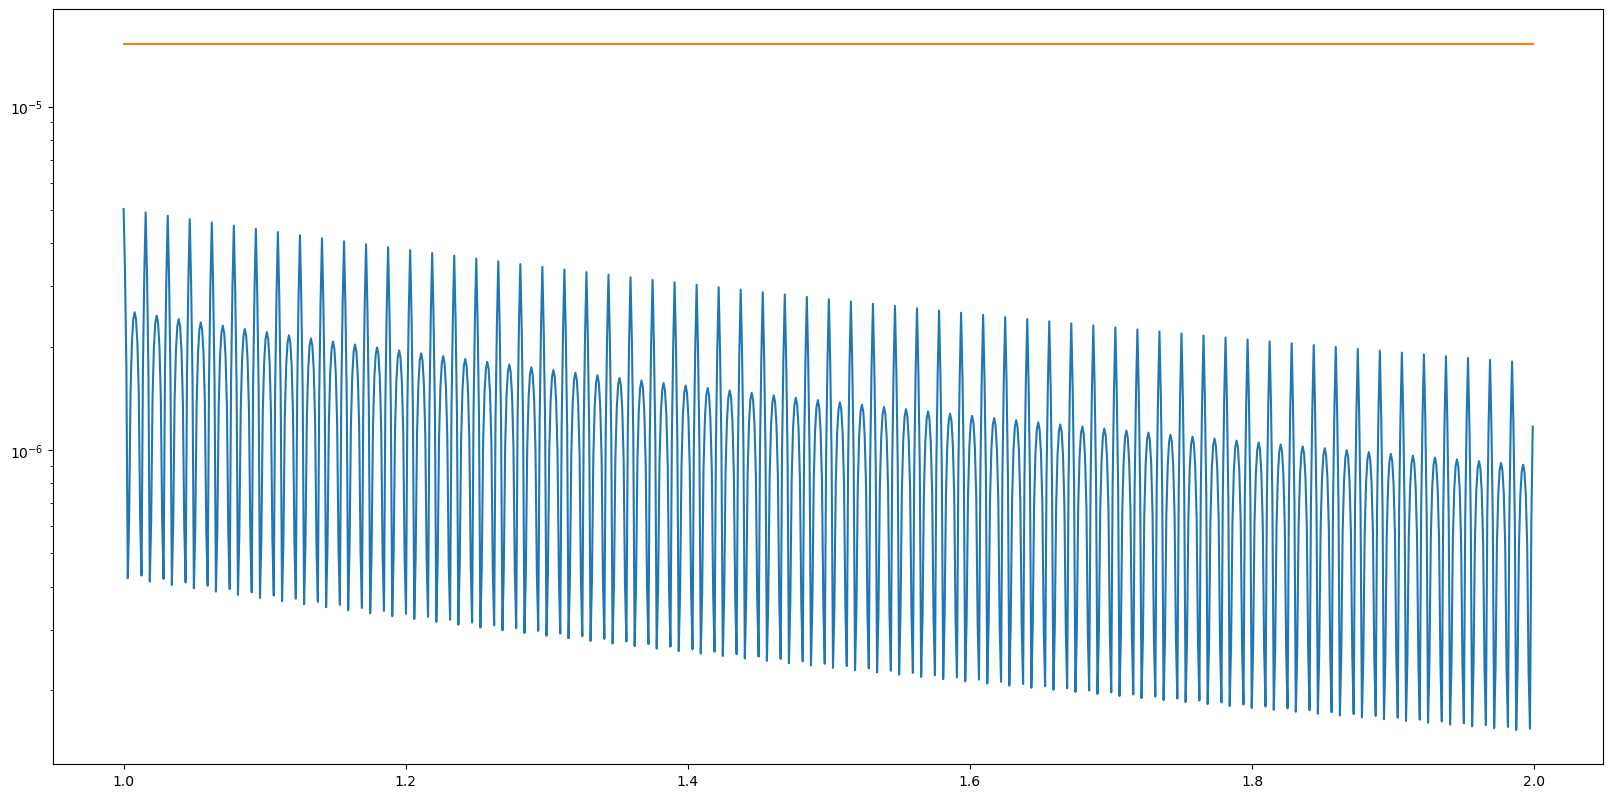

In [9]:
x = np.linspace(1, 2, 1024, endpoint=False)

plt.figure(figsize=(20, 10))
plt.plot(x, np.abs(approximate_from_table(sqrt_table_0, 1, 2, x) - np.sqrt(x) + 1))
plt.plot(x, np.ones_like(x) * 2**-16)
plt.yscale("log")
# plt.ylim((10**-10, 1))

In [10]:
(log_table * 2**30).astype(int)[:,::-1].flatten()[0::3] / 2**30;

In [11]:
def build_format_string(widths):
    s = ""
    for width in widths:
        s = s + "{:0" + str(width) + "b}"
    return s

In [12]:
def format_binary_string(din, length):
    return ("{:0" + str(length) + "b}").format(din)

In [13]:
def gen_rom(table, power, widths, signmod):
    fxpnt_table = (table * 2**power * signmod).astype(int)
    fmt = build_format_string(widths)
    # fmt.format(x[0] & ((2**widths[0])-1), x[1] & ((2**widths[1])-1), x[2] & ((2**widths[2])-1))
    return ["".join([format_binary_string(s & ((2**widths[i])-1), widths[i]) for i,s in enumerate(x)]) for x in fxpnt_table]

In [14]:
def print_rom(rom, tabs=2):
    print(repr(rom).replace("'", '"'))

In [15]:
log_rom = gen_rom(log_table, 30, np.array([14, 23, 31]), np.array([1, 1, 1]))

In [16]:
# print_rom(log_rom)

In [17]:
sqrt_rom_0 = gen_rom(sqrt_table_0, 18, np.array([13, 19]), np.array([1,1]))
sqrt_rom_1 = gen_rom(sqrt_table_1, 18, np.array([13, 19]), np.array([1,1]))

sqrt_rom = sqrt_rom_0 + sqrt_rom_1

In [18]:
(sqrt_table_1[0x4f-64] * 2**18).astype(int)

array([  2598, 149744])

In [19]:
# print_rom(sqrt_rom)

In [20]:
(sin_table[int(0.6231689453125 * 128)] * 2**17).astype(int)

array([   901, 108081])

In [21]:
sin_rom = gen_rom(sin_table, 17, np.array([12, 19]), np.ones(2))
cos_rom = gen_rom(cos_table, 17, np.array([12, 19]), np.ones(2))

In [22]:
print_rom(np.core.defchararray.add(np.array(sin_rom), np.array(cos_rom)))

array(["01100100100000000000000000000001111111101110100000000000000001",
       "01100100100000000000110010010001111111000110011111111111110111",
       "01100100011100000001100100100001111110011110011111111111011010",
       "01100100011100000010010110110001111101110110011111111110101000",
       "01100100011000000011001000111111111101010000011111111101100011",
       "01100100010000000011111011001011111100101000011111111100001010",
       "01100100001100000100101101010101111100000000011111111010011110",
       "01100100000100000101011111011011111011011010011111111000011110",
       "01100011111100000110010001011111111010110010011111110110001010",
       "01100011110100000111000011011111111010001010011111110011100011",
       "01100011101100000111110101011001111001100100011111110000100111",
       "01100011100000001000100111001111111000111100011111101101011001",
       "01100011010100001001011001000001111000010110011111101001110110",
       "0110001100100000101000101010110111011110111

In [23]:
cos_rom[0][12:]

'0100000000000000001'

# Some integer arithmetic

## Elemental Functions

### The fixed point natural logarithm

Let $x$ be a real number in fixed point representation, with $IB_x$ integer bits, and $FB_x$ fraction bits.

Then $x$ can be written as $2^E * M$, where $M \in [1,2)$, and $E \in \{(-FB_x) ... (IB_x-1)\}$

The natural logarithm of $x$, $\ln{x}$, can then be reduced to the following problem:
$\ln{x} = \ln{(2^E * M)} = \ln{2^E} + \ln{M} = E * \ln{2} + \ln{M}$.

E can be determined by counting the leading zeros of $x$.

Let $IB_X = FB_x = 4$, $x = 0101.0110$. Then $M = 1.010110$ and $E = 2 = IB_x - 1 - 1$. We can then put together $ln(x) = 2 * \ln(2) + \ln(M)$, where $M$ will be calculated using a piecewise polynomial.

Alternatively let $x = 0000.0110$. Then $M = 1.10$ and $E = -2 = IB_x - 1 - 5$.


In [24]:
2 * np.log(2) + np.log(int("1010110", 2) / 64)

1.6817585740137264

In [25]:
np.log(int("1010110", 2) / 16)

1.6817585740137264

# Verification

In [26]:
def lzd(x, l):
    return l-(len(bin(x))-2)

In [27]:
def gaussian(u_0, u_1, u_2):
    exp_e = lzd(u_0, 48) + 1
    e = 2 * (np.log(2) * exp_e - np.log(1+u_2*2**-31))
    
    f = np.sqrt(e)
    
    return (np.sin(2*np.pi*u_1*2**-16)*f, np.cos(2*np.pi*u_1*2**-16)*f)

In [28]:
gaussian(0xc63ef7f1ec5a, 0x6e43, 0x716be206)

(0.14442150852363367, -0.3104984098583701)